# The Computer Vision Challenge
#### How might we automate the process of recognizing the details of the vehicles from images, including make and model?

This is a data science assignment where you are expected to create a data model from a given training dataset.

### PROBLEM STATEMENT

#### Given a dataset of distinct car images, can you automatically recognize the car model and make?

You can use the ["Cars"](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) dataset and the ["Training"](http://imagenet.stanford.edu/internal/car196/cars_train.tgz) dataset for this challenge. 

You are expected to create a Data Model based on the ["Cars"](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) dataset in order to solve the problem statement(s).

You should also provide step by step documentation on how to run your code. Our evaluators will be running your data models on a test dataset.

#### ===========================
###  &nbsp;&nbsp;&nbsp;  Solution Performance
#### ===========================

In 6 runs using the Parameters/Hyper-Parameters and ResNet152 model below, and the environment in Part 6, the test accuracies achieved are as follows:

### 92.39%, 92.39%, 92.51%, 92.54%, 92.54%, and 92.55% 

# IMPORTANT NOTE TO EVALUATORS: 
### When making predictions on the Test dataset in Part 3, we make use of the test annotations file ["cars_test_annos_withlabels.mat"](http://imagenet.stanford.edu/internal/car196/cars_test_annos_withlabels.mat).
### Download this file and place it in DATA_PATH, together with the files cars_train.tgz, cars_test.tgz, and car_devkit.tgz.

# Beginning Folder Structure (should look like this):
<img src="folder_structure.jpg" align="left"></img>

#### These three lines ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Load libraries

Import all the necessary packages. We are going to work with the [fastai V1 library](https://docs.fast.ai/) which sits on top of [Pytorch 1.1](https://pytorch.org/docs/stable/index.html). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

### For this solution, we are using these specific Python packages
#### Package/Version
. python       [3.6.8] <br/>
. numpy        [1.16.2]<br/>
. pandas       [0.24.2]<br/>
. matplotlib   [3.0.3] <br/>
. scipy        [1.2.1] <br/>
. opencv       [4.1.0] <br/>
. fastai       [1.0.53.post2]<br/>
. pytorch      [1.1.0] <br/>
. torchvision  [0.2.2]

In [2]:
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *

import cv2 as cv
import numpy as np
import pandas as pd
from scipy.io import loadmat

import os
import random
from console_progressbar import ProgressBar

## Parameters/Hyper-Parameters

In [3]:
IMG_WIDTH = IMG_HEIGHT = IMG_SIZE = 224

SEED  = 117
SPLIT = 0.90 # train/valid split

MAX_ROT     = 5.0 # max_rotate
B_SIZE      = 16  # batch_size
N_WORKERS   =  8  # num_workers

DATA_PATH   = './data/'
CARS_TRAIN  = 'cars_train'
CARS_TEST   = 'cars_test'
CAR_DEVKIT  = 'car_devkit'
DEVKIT      = 'devkit'

TRAIN_PATH  = DATA_PATH + 'train'
VALID_PATH  = DATA_PATH + 'valid'
TEST_PATH   = DATA_PATH + 'test'
MODELS_PATH = DATA_PATH + 'models'

## Model

In [4]:
RESNET152   = models.resnet152

## Metrics

In [5]:
METRICS = [accuracy,top_k_accuracy]

# Part 1. Extract, process, transform, and train (TRAIN)

In [6]:
import time
since = time.time()

## Clear folder structure

In [7]:
import shutil

if os.path.exists(CARS_TRAIN):
    shutil.rmtree(CARS_TRAIN)
if os.path.exists(CARS_TEST):
    shutil.rmtree(CARS_TEST)
if os.path.exists(DEVKIT):
    shutil.rmtree(DEVKIT)
    
if os.path.exists(TRAIN_PATH):
    shutil.rmtree(TRAIN_PATH)
if os.path.exists(VALID_PATH):
    shutil.rmtree(VALID_PATH)
if os.path.exists(TEST_PATH):
    shutil.rmtree(TEST_PATH)
if os.path.exists(MODELS_PATH):
    shutil.rmtree(MODELS_PATH)

## Extract train and devkit files

In [8]:
def extract_train_and_devkit():
    print('Extracting {}.tgz...'.format(CARS_TRAIN))
    if not os.path.exists(CARS_TRAIN):
        with tarfile.open(DATA_PATH + CARS_TRAIN + '.tgz', "r:gz") as tar:
            tar.extractall()
    print('Extracting {}.tgz...'.format(CAR_DEVKIT))
    if not os.path.exists(DEVKIT):
        with tarfile.open(DATA_PATH + CAR_DEVKIT + '.tgz', "r:gz") as tar:
            tar.extractall()

extract_train_and_devkit()

Extracting cars_train.tgz...
Extracting car_devkit.tgz...


## Process the train data

In [9]:
def generate_train_and_valid_data(fnames, labels, bboxes):
    src_folder  = CARS_TRAIN + '/'
    num_samples = len(fnames)

    train_split = SPLIT
    num_train = int(round(num_samples * train_split))
    random.seed(SEED)
    train_indexes = random.sample(range(num_samples), num_train)

    pbar = ProgressBar(total=100,  prefix='', suffix='', 
                       decimals=1, length=50, fill='#')

    for i in range(num_samples):
        fname = fnames[i]
        label = labels[i]
        (x1, y1, x2, y2) = bboxes[i]

        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        
        pbar.print_progress_bar((i + 1) * 100 / num_samples)

        if i in train_indexes:
            dst_folder = TRAIN_PATH
        else:
            dst_folder = VALID_PATH

        dst_path = os.path.join(dst_folder, label)
        if not os.path.exists(dst_path):
            os.makedirs(dst_path)
        dst_path = os.path.join(dst_path, fname)

        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(IMG_HEIGHT, IMG_WIDTH))
        cv.imwrite(dst_path, dst_img)

def process_train_data():
    print("Processing train data...")
    cars_annos = loadmat(DEVKIT + '/cars_train_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    class_ids = []
    bboxes = []
    labels = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        class_id = annotation[0][4][0][0]
        labels.append('%04d' % (class_id,))
        fname = annotation[0][5][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        class_ids.append(class_id)
        fnames.append(fname)

    labels_count = np.unique(class_ids).shape[0]
    print('Number of classes: %d' % labels_count)

    generate_train_and_valid_data(fnames, labels, bboxes)

In [10]:
os.makedirs(TRAIN_PATH)
os.makedirs(VALID_PATH)

process_train_data()

# Clean up
if os.path.exists(CARS_TRAIN):
    shutil.rmtree(CARS_TRAIN)

Processing train data...
Number of classes: 196
 |##################################################| 100.0% 


## Train/Valid Dataset:  Using SPLIT = 0.90
### Train: 7,330 Files; Valid: 814 Files

## Load cars meta information

In [11]:
cars_meta = loadmat(DEVKIT + '/cars_meta.mat')
class_names = cars_meta['class_names']
class_names = np.transpose(class_names)

## Create data batches using ImageDataBunch

In [12]:
data = ImageDataBunch.from_folder(DATA_PATH, 'train', 'valid', 
                                  ds_tfms=get_transforms(do_flip=False, flip_vert=True, max_rotate=MAX_ROT), 
                                  size=IMG_SIZE, num_workers=N_WORKERS, bs=B_SIZE).normalize(imagenet_stats)

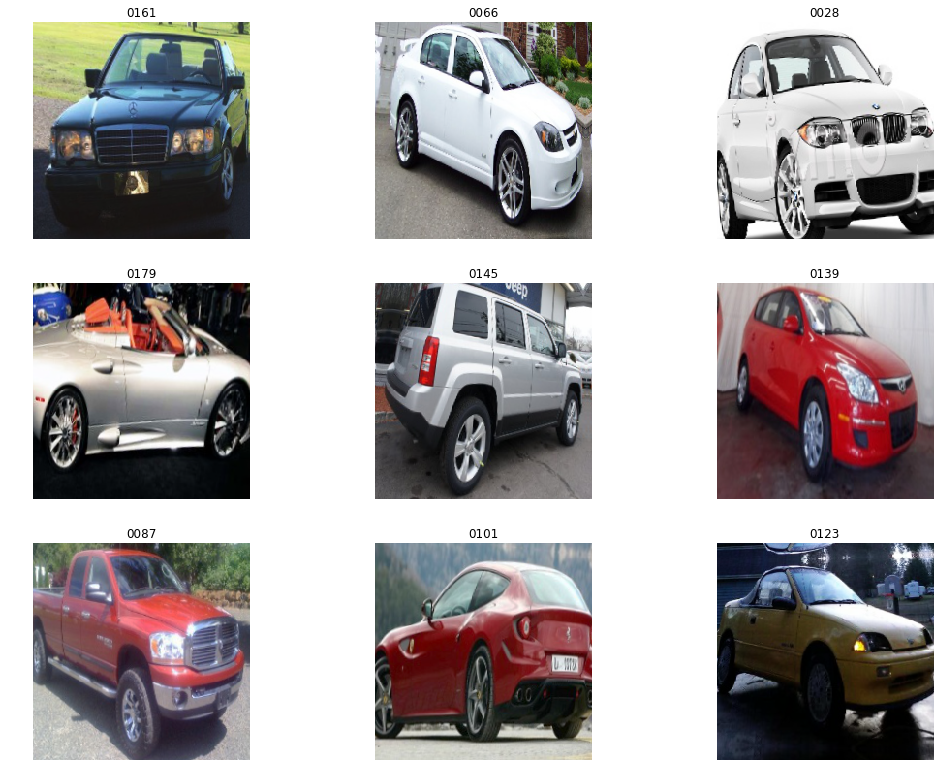

In [13]:
data.show_batch(rows=3, figsize=(15,11))

## Train using fast.ai's cnn_learner and resnet152

In [14]:
learn = cnn_learner(data, RESNET152, metrics=METRICS)

In [15]:
NUM_EPOCHS = 30
learn.fit_one_cycle(NUM_EPOCHS)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.831569,4.211161,0.137592,0.348894,04:18
1,3.821298,3.288335,0.293612,0.593366,04:28
2,2.785427,2.385715,0.457002,0.748157,04:39
3,2.037226,1.671377,0.579853,0.863636,04:34
4,1.552575,1.298999,0.627764,0.905405,04:36
5,1.390545,1.173982,0.668305,0.902948,05:32
6,1.170242,1.079811,0.702703,0.928747,05:01
7,1.076670,1.022353,0.721130,0.929975,04:37
8,0.986744,1.019708,0.729730,0.927518,05:33
9,0.887279,0.914825,0.759214,0.932432,04:30


In [16]:
preds, y, loss = learn.get_preds(with_loss=True)
acc = accuracy(preds, y)
print('Accuracy: {0:.2f}%.'.format(acc*100)) # Accuracy: 87.84%, 87.59%

Accuracy: 87.96%.


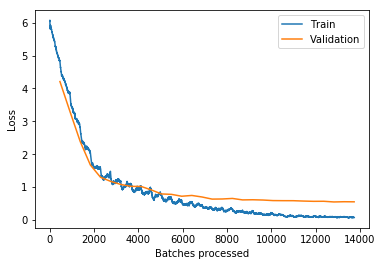

In [17]:
learn.recorder.plot_losses()

## Save the model

In [18]:
learn.save('Stage-1-ResNet152')

## Check initial results
Let's see what results we have got. 

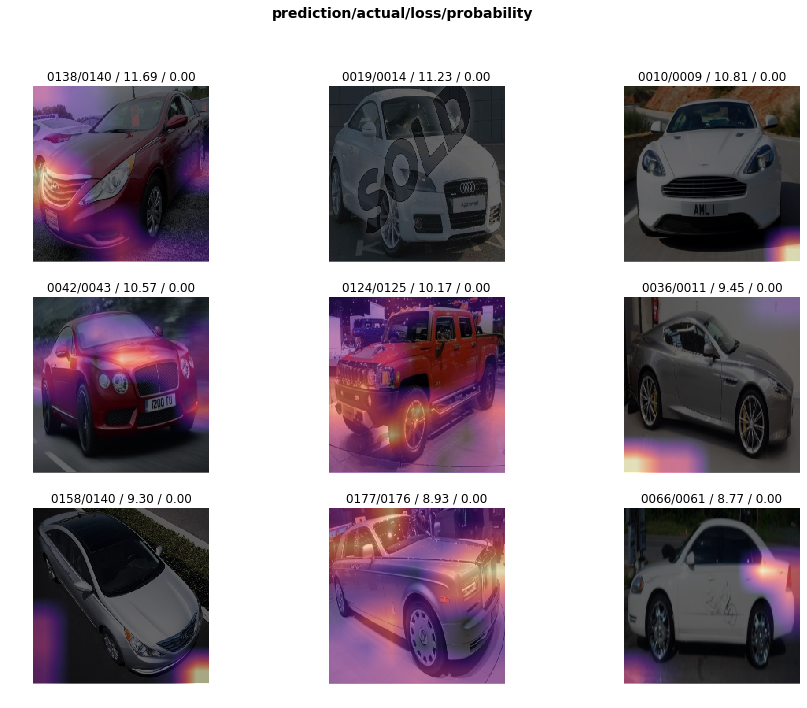

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

interp.plot_top_losses(9, figsize=(15,11))

In [20]:
interp.most_confused(min_val=2)

[('0014', '0019', 3),
 ('0036', '0031', 2),
 ('0056', '0055', 2),
 ('0056', '0057', 2),
 ('0064', '0119', 2),
 ('0065', '0054', 2),
 ('0088', '0166', 2)]

In [21]:
time_elapsed = time.time() - since
print()
print('Time elapsed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# Time elapsed: 155m 32s, 148m 55s


Time elapsed: 152m 7s


# BREAK! Part 1 done...

# Part 2. Extract and process (TEST)

In [22]:
since = time.time()

## Extract test files

In [23]:
def extract_test_files():
    print('Extracting {}.tgz...'.format(CARS_TEST))
    if not os.path.exists(CARS_TEST):
        with tarfile.open(DATA_PATH + CARS_TEST  + '.tgz', "r:gz") as tar:
            tar.extractall()
            
extract_test_files()

Extracting cars_test.tgz...


## Process the test data

In [24]:
def generate_test_data(fnames, bboxes):
    src_folder = CARS_TEST + '/'
    dst_folder = TEST_PATH
    num_samples = len(fnames)

    pbar = ProgressBar(total=100,  prefix='', suffix='', 
                       decimals=1, length=50, fill='#')

    for i in range(num_samples):
        fname = fnames[i]
        (x1, y1, x2, y2) = bboxes[i]
        src_path = os.path.join(src_folder, fname)
        src_image = cv.imread(src_path)
        height, width = src_image.shape[:2]
        
        margin = 16
        x1 = max(0, x1 - margin)
        y1 = max(0, y1 - margin)
        x2 = min(x2 + margin, width)
        y2 = min(y2 + margin, height)
        
        pbar.print_progress_bar((i + 1) * 100 / num_samples)

        dst_path = os.path.join(dst_folder, fname)
        crop_image = src_image[y1:y2, x1:x2]
        dst_img = cv.resize(src=crop_image, dsize=(IMG_HEIGHT, IMG_WIDTH))
        cv.imwrite(dst_path, dst_img)

def process_test_data():
    print("Processing test data...")
    cars_annos = loadmat(DEVKIT + '/cars_test_annos.mat')
    annotations = cars_annos['annotations']
    annotations = np.transpose(annotations)

    fnames = []
    bboxes = []

    for annotation in annotations:
        bbox_x1 = annotation[0][0][0][0]
        bbox_y1 = annotation[0][1][0][0]
        bbox_x2 = annotation[0][2][0][0]
        bbox_y2 = annotation[0][3][0][0]
        fname = annotation[0][4][0]
        bboxes.append((bbox_x1, bbox_y1, bbox_x2, bbox_y2))
        fnames.append(fname)

    generate_test_data(fnames, bboxes)

In [25]:
os.makedirs(TEST_PATH)

process_test_data()

# Clean up
if os.path.exists(CARS_TEST):
    shutil.rmtree(CARS_TEST)
if os.path.exists(DEVKIT):
    shutil.rmtree(DEVKIT)

Processing test data...
 |##################################################| 100.0% 


## Unfreeze and fine-tune
Since the model is working as expected, let's *unfreeze* it and train some more.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


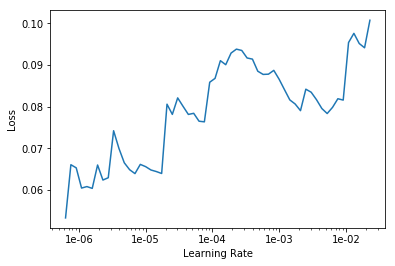

In [26]:
learn.lr_find()
learn.recorder.plot()

In [27]:
NUM_EPOCHS = 30
learn.unfreeze()
learn.fit_one_cycle(NUM_EPOCHS, max_lr=slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.101129,0.552175,0.863636,0.974202,05:28
1,0.171910,0.604637,0.858722,0.970516,05:38
2,0.242211,0.743024,0.843980,0.959459,05:38
3,0.347197,0.713188,0.824324,0.966830,05:35
4,0.494276,0.816427,0.807125,0.949631,05:38
5,0.532524,0.688439,0.819410,0.965602,05:39
6,0.556424,0.776373,0.804668,0.948403,05:42
7,0.536302,0.786058,0.792383,0.955774,05:39
8,0.438507,0.629470,0.831695,0.972973,05:42
9,0.320186,0.609666,0.843980,0.968059,05:37


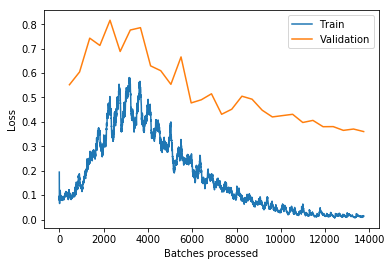

In [28]:
learn.recorder.plot_losses()

In [29]:
time_elapsed = time.time() - since
print()
print('Time elapsed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# Time elapsed: 177m 23s, 193m 6s


Time elapsed: 176m 55s


# BREAK! Part 2 done...

# Part 3. Make predictions

In [30]:
since = time.time()

In [31]:
learn.export('./export.pkl')

## Load cars_test label information

In [32]:
labels = loadmat(DATA_PATH + 'cars_test_annos_withlabels.mat')

## FINALLY - Predict!

In [33]:
NUM_TEST_IMAGES = 8041

idx = []
for i in range(NUM_TEST_IMAGES):
    idx.append(np.transpose(np.array(labels['annotations']['fname']))[i][0][0])

In [34]:
df = pd.DataFrame(data=np.transpose(np.array(labels['annotations']['class'], dtype=np.int)), index=idx)
df.to_csv(DATA_PATH + 'test_labels.csv')

In [35]:
learn = load_learner(DATA_PATH, test=ImageList.from_csv('./data/', 'test_labels.csv', folder='./test'))

In [36]:
preds, _ = learn.TTA(ds_type=DatasetType.Test)

In [37]:
d = np.asarray(np.array(labels['annotations']['class'], dtype=np.int)-1).T
d = torch.from_numpy(d)
y = np.squeeze(d).long()

## Compute Accuracy

In [38]:
acc = accuracy(preds, y)
print('Test Accuracy: {0:.2f}%.'.format(acc*100)) # Test Accuracy: 92.39%, 92.54%

Test Accuracy: 92.55%.


In [39]:
time_elapsed = time.time() - since
print()
print('Time elapsed: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# Time elapsed: 13m 21s, 13m 34s


Time elapsed: 13m 33s


# BREAK! Part 3 done...

# Part 4. Generate prediction probabilities file

In [40]:
print(preds.shape)

preds_n = preds.numpy()
print(len(preds_n[0]), len(preds_n))

torch.Size([8041, 196])
196 8041


In [41]:
preds_d = dict()
for i in range(len(preds_n)):
    preds_d[i+1] = (int(np.argmax(preds_n[i]))+1, np.max(preds_n[i]))

In [42]:
preds_proba = list(preds_d.values())

# Quick sanity check!
print(preds_proba[0], preds_proba[8040])

(181, 0.9988179) (32, 0.9973124)


In [43]:
np.savetxt(DATA_PATH + '/preds_proba.csv', preds_proba, fmt=['%3d','%1.7f'], delimiter=',')

## Output Confidence Score for Every Classification

In [44]:
np.savetxt(DATA_PATH + '/preds_proba_ALL.csv', preds, delimiter=',')

# Part 5. Compute Precision and Recall

In [45]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [46]:
y_labels = df[0].tolist()

y_hat = [x[0] for x in preds_proba]

In [47]:
# accuracy:  (tp + tn) / (p + n)
accuracy  = accuracy_score(y_labels, y_hat)
print('Accuracy:  %.4f' % accuracy) # 0.9254

Accuracy:  0.9255


In [48]:
# precision: tp / (tp + fp)
precision = precision_score(y_labels, y_hat, average='macro')
print('Precision: %.4f' % precision) # 0.9263

Precision: 0.9276


In [49]:
# recall:    tp / (tp + fn)
recall    = recall_score(y_labels, y_hat, average='macro')
print('Recall:    %.4f' % recall) # 0.9242

Recall:    0.9246


# THE END!

# Part 6. Display solution environment

In [50]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python        : 3.6.8
fastai        : 1.0.53.post2
fastprogress  : 0.1.21
torch         : 1.1.0
nvidia driver : 419.67
torch cuda    : 10.0 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 8192MB | GeForce GTX 1070

=== Environment === 
platform      : Windows-10-10.0.17763-SP0
conda env     : pt11
python        : D:\Ana3x\envs\pt11\python.exe
sys.path      : D:\Ana3x\envs\pt11\python36.zip
D:\Ana3x\envs\pt11\DLLs
D:\Ana3x\envs\pt11\lib
D:\Ana3x\envs\pt11

C:\Users\MSJose2K5\AppData\Roaming\Python\Python36\site-packages
D:\Ana3x\envs\pt11\lib\site-packages
D:\Ana3x\envs\pt11\lib\site-packages\win32
D:\Ana3x\envs\pt11\lib\site-packages\win32\lib
D:\Ana3x\envs\pt11\lib\site-packages\Pythonwin
D:\Ana3x\envs\pt11\lib\site-packages\IPython\extensions
C:\Users\MSJose2K5\.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear for

# Epilogue

Thanks to the organizers of the **Grab AI FOR S.E.A. Challenge**.<br/>
It was a fun and challenging 3-1/2 weeks doing the Computer Vision portion and chasing state-of-the-art model performance on the Stanford Cars Dataset.<br/>
<br/>
msjose2k5@gmail.com<br/>
Sunday, June 16, 2019 03:30 PM PDT